In [ ]:
# Copyright (c) 2025, ETH Zurich

In [2]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tqdm import tqdm
import os

In [4]:
import h5py

In [6]:
rave_sim_dir = Path('path/to/rave-sim')
simulations_dir = Path('path/to/data/')
scratch_dir = simulations_dir

In [7]:
sys.path.insert(0, str(rave_sim_dir / "big-wave"))
import multisim
import config
import util
from nist_lookup.xraydb_plugin import xray_delta_beta

In [8]:
# constants
h = 6.62607004 * 10**(-34) # planck constant in mˆ2 kg / s
c_0 = 299792458 # speed of light in m / s
eV_to_joule = 1.602176634*10**(-19)
N_A = 6.02214086 * 10**23 #[1/mol]

In [9]:
import scipy.signal as scis
def ph_grat(x, dc=0.5, p=42e-7, ph_stp=0, ph_steps=5, th = 0, shift=None):
    return (1+scis.square(2 * np.pi * (x / p + ph_stp/ph_steps + 1/4 + shift + (dc-0.5)/2) , duty = dc))/2

In [10]:
def bin_me_res(data, x_axis, new_dx, axis=-2):
    """
    data must have dimensions:
    [x, z]
    """
    if axis!=-2:
        data = np.swapaxes(data, axis, -2)
    dx = abs(x_axis[1]-x_axis[0])
    binning = int(new_dx/dx)
    bin_range= int(data.shape[-2]/binning)
    if binning<2:
        print("no binnin necessary")
        return data
    sol = np.zeros((*data.shape[:-2],int(data.shape[-2]/binning),data.shape[-1]))
    new_x_grid = []
    for i in range(bin_range):
        sol[...,i,:] = np.sum(data[...,i*binning:(i+1)*binning,:], axis=-2)#[:,np.newaxis, :]
        new_x_grid.append(x_axis[...,i*binning+int(binning/2)])
    if axis!=-2:
        sol = np.swapaxes(sol, -2, axis)
    return sol, np.asarray(new_x_grid)

# Full_interferometer

In [ ]:
# interferometer with source grating

In [11]:
import spekpy as spk
from scipy import interpolate

In [12]:
s = spk.Spek(kvp=100, dk = 0.1, th = 90) # Create a spectrum
s.multi_filter((('Be', 0.15), ('Al', 5), ('Water', 200))) # Create a spectrum
k, f = s.get_spectrum(edges=True) # Get the spectrum

energyRange = [10000, 100000]
dE = 100
filtering = 0.000

energies = np.arange(10, 100+0.1, 0.1)*1e3


tube_spectrum_txt = interpolate.interp1d(k*1e3, f, fill_value = 'extrapolate')
spec_txt = tube_spectrum_txt(energies)

# with h5py.File('path/to/simulation_spectrum_file.h5', 'w') as h5:
#     h5.create_dataset('pdf', data =  spec_txt/ np.sum(spec_txt))
#     h5.create_dataset('energy', data = energies)

(0.0, 10000.0)

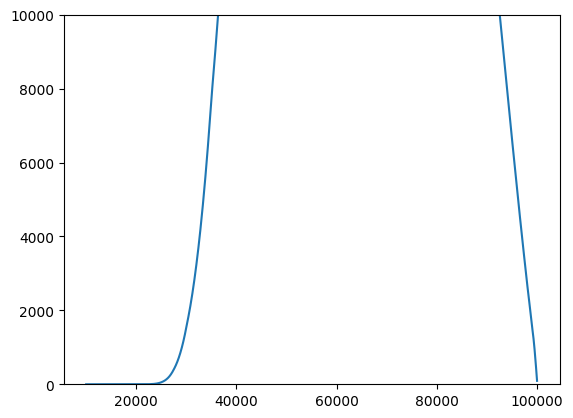

In [13]:
plt.plot(energies,spec_txt)
plt.ylim(0,0.1e5)

In [14]:
dba_path_500 = "path/to/full/dba/simulation"

In [15]:
att_path_500 = "path/to/full/attenuation/simulation"

In [16]:
wfs_dba_500 = util.load_wavefronts_filtered(dba_path_500, x_range=None, energy_range=None)
wfs_att_500 = util.load_wavefronts_filtered(att_path_500, x_range=None, energy_range=None)

In [17]:
wf_dba_500 = []
wf_att_500 = []
eng_att_500 = []
eng_dba_500 = []
for i in range(500):
    wf_dba_500.append(wfs_dba_500[i][0])
    wf_att_500.append(wfs_att_500[i][0])
    eng_att_500.append(wfs_att_500[i][2])
    eng_dba_500.append(wfs_dba_500[i][2])
wf_dba_500 = np.asarray(wf_dba_500)
eng_dba_500 = np.asarray(eng_dba_500)
wf_att_500 = np.asarray(wf_att_500)
eng_att_500 = np.asarray(eng_att_500)

In [18]:
eng_spectral_500 = tube_spectrum_txt(eng_dba_500)

In [19]:
eng_spectral_500 = eng_spectral_500/eng_spectral_500.sum()

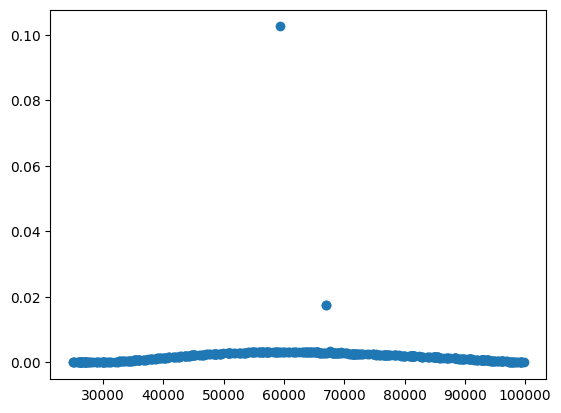

In [20]:
plt.scatter(eng_dba_500,eng_spectral_500)

In [21]:
wf_dba_500.shape

(500, 11, 2000)

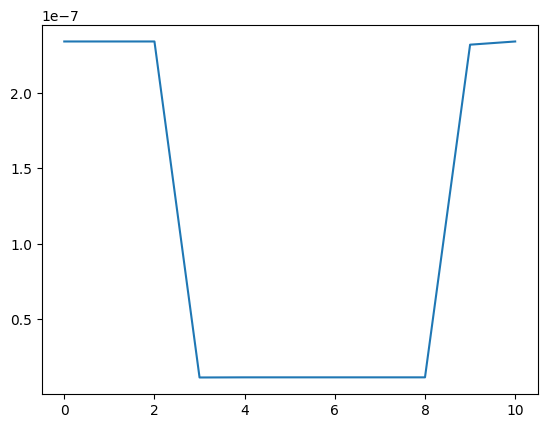

In [22]:
plt.plot(wf_dba_500[0,:,1000])

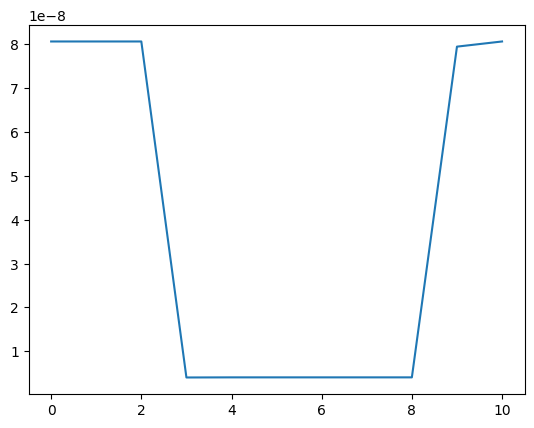

In [23]:
plt.plot(wf_att_500[0,:,1000])

In [24]:
sorting_500 = np.argsort(eng_dba_500)

In [25]:
psc_dba_500 = (wf_dba_500[...,950:1050]).sum(axis=(0,-1))

In [26]:
psc_dba_500 = (wf_dba_500[...,900:1100]*eng_spectral_500[:,np.newaxis, np.newaxis]).sum(axis=(0,-1))

In [27]:
psc_dba_500 = (wf_dba_500[...,500:1500]*eng_spectral_500[:,np.newaxis, np.newaxis]).sum(axis=(0,-1))

In [28]:
(psc_dba_500.max()-psc_dba_500.min())/(psc_dba_500.max()+psc_dba_500.min())

0.28527705371649875

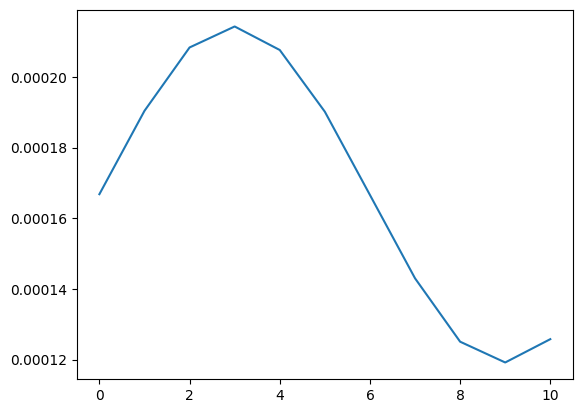

In [29]:
plt.plot(psc_dba_500)

In [30]:
psc_att_500 = (wf_att_500[...,900:1100]).sum(axis=(0,-1))

In [31]:
psc_att_500 = (wf_att_500[...,900:1100]*eng_spectral_500[:,np.newaxis, np.newaxis]).sum(axis=(0,-1))

In [32]:
psc_att_500 = (wf_att_500[...,500:1500]*eng_spectral_500[:,np.newaxis, np.newaxis]).sum(axis=(0,-1))

In [33]:
(psc_att_500.max()-psc_att_500.min())/(psc_att_500.max()+psc_att_500.min())

0.3261840583231631

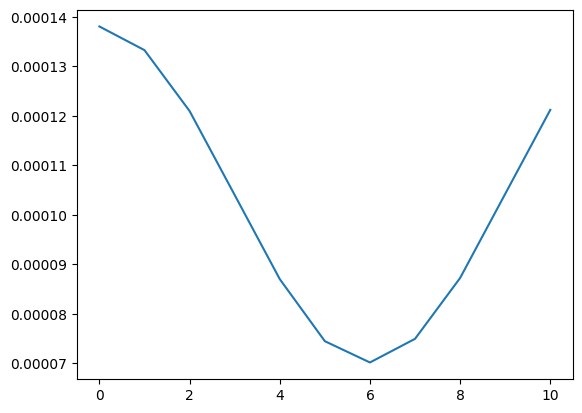

In [34]:
plt.plot(psc_att_500)

In [35]:
psc_dba_500.sum()/psc_att_500.sum()

1.664895121281862

In [36]:
(psc_dba_500.max()-psc_dba_500.min())/(psc_dba_500.max()+psc_dba_500.min())*(psc_dba_500.sum())**0.5

0.012294682598446821

In [37]:
(psc_att_500.max()-psc_att_500.min())/(psc_att_500.max()+psc_att_500.min())*(psc_att_500.sum())**0.5

0.01089481279915026

# Idealized Interferometer

In [ ]:
# interferometers with point source

In [38]:
sim_path_tri = 'path/to/tiang5x/simulation/data'
sim_path_tli = 'path/to/tli/simulation/data'
sim_path_dba_inv = 'path/to/dba/simulation/data'
sim_path_abso400 = "path/to/att400um/simulation/data"
sim_path_abso = "path/to/att300um/simulation/data"

In [39]:
wfs_tli = util.load_wavefronts_filtered(sim_path_tli, x_range=None, energy_range=None)
wfs_tri = util.load_wavefronts_filtered(sim_path_tri, x_range=None, energy_range=None)
wfs_dba_inv = util.load_wavefronts_filtered(sim_path_dba_inv, x_range=None, energy_range=None)
wfs_abs400 = util.load_wavefronts_filtered(sim_path_abso400, x_range=None, energy_range=None)
wfs_abs = util.load_wavefronts_filtered(sim_path_abso, x_range=None, energy_range=None)

In [40]:
wf_tli = []
wf_tri = []
eng_tli = []
wf_dba_inv = []
wf_abs400 = []
wf_abs = []
for i in range(2000):
    wf_tli.append(wfs_tli[i][0])
    wf_tri.append(wfs_tri[i][0])
    eng_tli.append(wfs_tli[i][2])
    wf_abs400.append(wfs_abs400[i][0])
    wf_dba_inv.append(wfs_dba_inv[i][0])
    wf_abs.append(wfs_abs[i][0])
wf_tri = np.asarray(wf_tri)
wf_tli = np.asarray(wf_tli)
eng_tli = np.asarray(eng_tli)
wf_dba_inv = np.asarray(wf_dba_inv)
wf_abs400 = np.asarray(wf_abs400)
wf_abs = np.asarray(wf_abs)

In [41]:
my_x = util.full_x_vector(wf_tli.shape[-1], 1e-6)

In [42]:
analyser = ph_grat(my_x[:,np.newaxis], dc=0.5, p=40e-6, ph_stp=np.linspace(0,25,26)[np.newaxis,:], ph_steps=25.0, th = 0, shift=0)

In [43]:
wf_tli.shape

(2000, 1, 3000)

In [44]:
wf_an_tli = wf_tli[...,np.newaxis]*analyser[np.newaxis,np.newaxis,...]
wf_an_tri = wf_tri[...,np.newaxis]*analyser[np.newaxis,np.newaxis,...]
wf_an_dba_inv = wf_dba_inv[...,np.newaxis]*analyser[np.newaxis,np.newaxis,...]
wf_an_abs400 = wf_abs400[...,np.newaxis]*analyser[np.newaxis,np.newaxis,...]
wf_an_abs = wf_abs[...,np.newaxis]*analyser[np.newaxis,np.newaxis,...]

In [45]:
def my_vis(data, axis):
    my_min = data.min(axis=axis)
    my_max = data.max(axis=axis)
    return (my_max-my_min)/(my_max+my_min)

In [46]:
siz = 40*4
centering = 1500
vis_an_tli = my_vis(wf_an_tli[:,:,centering-siz:centering+1+siz].sum(axis=-2), axis=-1)
vis_an_tri = my_vis(wf_an_tri[:,:,centering-siz:centering+1+siz].sum(axis=-2), axis=-1)
vis_an_dba_inv = my_vis(wf_an_dba_inv[:,:,centering-siz:centering+1+siz].sum(axis=-2), axis=-1)
vis_an_abs400 = my_vis(wf_an_abs400[:,:,centering-siz:centering+1+siz].sum(axis=-2), axis=-1)
vis_an_abs = my_vis(wf_an_abs[:,:,centering-siz:centering+1+siz].sum(axis=-2), axis=-1)

In [47]:
sorting = np.argsort(eng_tli)

In [48]:
# high energy mean visibility
cutoff_energy = 45000
print(45000/57000)
print(my_vis(wf_an_tli[eng_tli>cutoff_energy].sum(axis=(0))[0][abs(my_x)<40e-6].sum(axis=(0)), axis=0))
print(my_vis(wf_an_dba_inv[eng_tli>cutoff_energy].sum(axis=(0))[0][abs(my_x)<40e-6].sum(axis=(0)), axis=0))
print(my_vis(wf_an_tri[eng_tli>cutoff_energy].sum(axis=(0))[0][abs(my_x)<40e-6].sum(axis=(0)), axis=0))
print(my_vis(wf_an_abs[eng_tli>cutoff_energy].sum(axis=(0))[0][abs(my_x)<40e-6].sum(axis=(0)), axis=0))

0.7894736842105263
0.6256171569773243
0.560695705260399
0.6879043388902243
0.6863696918990597


In [49]:
# full spectrum visibility
print(my_vis(wf_an_tli[eng_tli<100000].sum(axis=(0))[0][abs(my_x)<40e-6].sum(axis=(0)), axis=0))
print(my_vis(wf_an_dba_inv[eng_tli<100000].sum(axis=(0))[0][abs(my_x)<40e-6].sum(axis=(0)), axis=0))
print(my_vis(wf_an_tri[eng_tli<100000].sum(axis=(0))[0][abs(my_x)<40e-6].sum(axis=(0)), axis=0))
print(my_vis(wf_an_abs[eng_tli<100000].sum(axis=(0))[0][abs(my_x)<40e-6].sum(axis=(0)), axis=0))

0.5315876251228566
0.46609508546896106
0.5530281266038459
0.6970379619634408


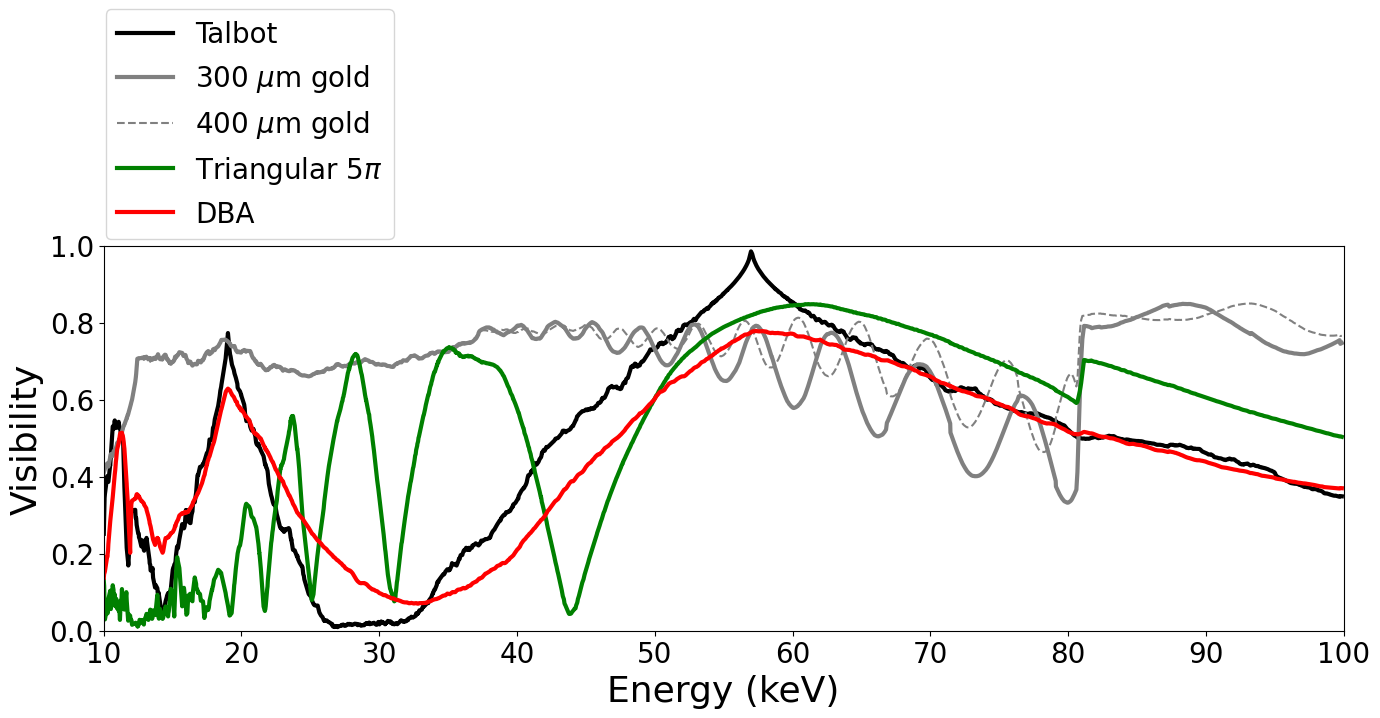

In [50]:
font_size=26
fig_, axs = plt.subplots(nrows = 1, ncols=1, figsize=(16,5))
design_energy=1000
kilo = 1000
plt.plot(eng_tli[sorting]/kilo, vis_an_tli[sorting,0], color="black", label="Talbot", linewidth=3)
plt.plot(eng_tli[sorting]/kilo, vis_an_abs[sorting,0], color="grey", label="300 $\mu$m gold", linewidth=3)
plt.plot(eng_tli[sorting]/kilo, vis_an_abs400[sorting,0], color="grey", label="400 $\mu$m gold", linestyle = "--")
plt.plot(eng_tli[sorting]/kilo, vis_an_tri[sorting,0], color="green", label=f"Triangular 5$\pi$", linewidth=3)#, {int(round(5*thick*1e6,0))} $\mu$m gold", linewidth=3)
plt.plot(eng_tli[sorting]/kilo, vis_an_dba_inv[sorting,0], color="red", label="DBA", linewidth=3)
plt.axvline(design_energy/kilo, color="grey", linestyle="--")
plt.legend(loc="upper right", fontsize=16, bbox_to_anchor=(1.35, 1))
plt.xlabel("Energy (keV)", fontsize=16)
plt.ylabel("Visibility", fontsize=16)
plt.xlim(10000/kilo, 100000/kilo)
plt.ylim(0,1)

axs.xaxis.label.set_size(font_size)
axs.yaxis.label.set_size(font_size)
axs.xaxis.set_tick_params(labelsize=font_size-6)
axs.yaxis.set_tick_params(labelsize=font_size-6)


axs.legend(loc="upper right", bbox_to_anchor=(0.245, 1.65), fontsize=font_size-6)

In [ ]:
# adding spectrum weights of 20 cm water propagation

In [51]:
import spekpy as spk
from scipy import interpolate

In [52]:
s = spk.Spek(kvp=100, dk = 0.1, th = 90) # Create a spectrum
s.multi_filter((('Be', 0.15), ('Al', 5), ('Water', 200))) # Create a spectrum
k, f = s.get_spectrum(edges=True) # Get the spectrum

energyRange = [10000, 100000]
dE = 100
filtering = 0.000

energies = np.arange(10, 100+0.1, 0.1)*1e3


tube_spectrum_txt = interpolate.interp1d(k*1e3, f, fill_value = 'extrapolate')
spec_txt = tube_spectrum_txt(energies)

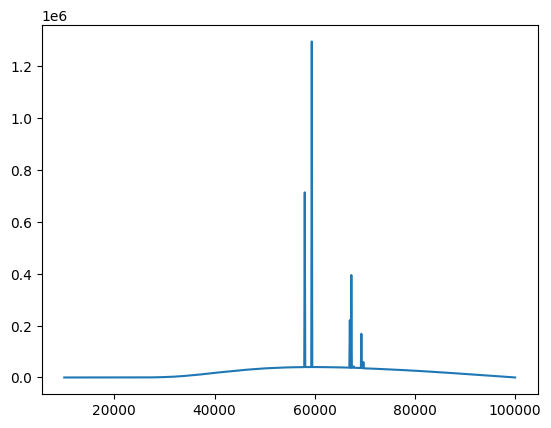

In [53]:
plt.plot(energies,spec_txt)

In [54]:
eng_spectral = tube_spectrum_txt(eng_tli)

In [55]:
eng_spectral = eng_spectral/eng_spectral.sum()

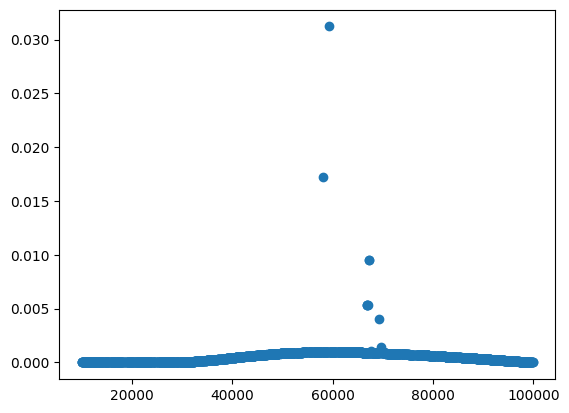

In [56]:
plt.scatter(eng_tli, eng_spectral)

In [57]:
np.where(vis_an_tli[sorting,0].max()==vis_an_tli[sorting,0])

(array([1004]),)

In [58]:
(vis_an_tli[sorting,0]*eng_spectral[sorting]).max()

0.027121550655160222

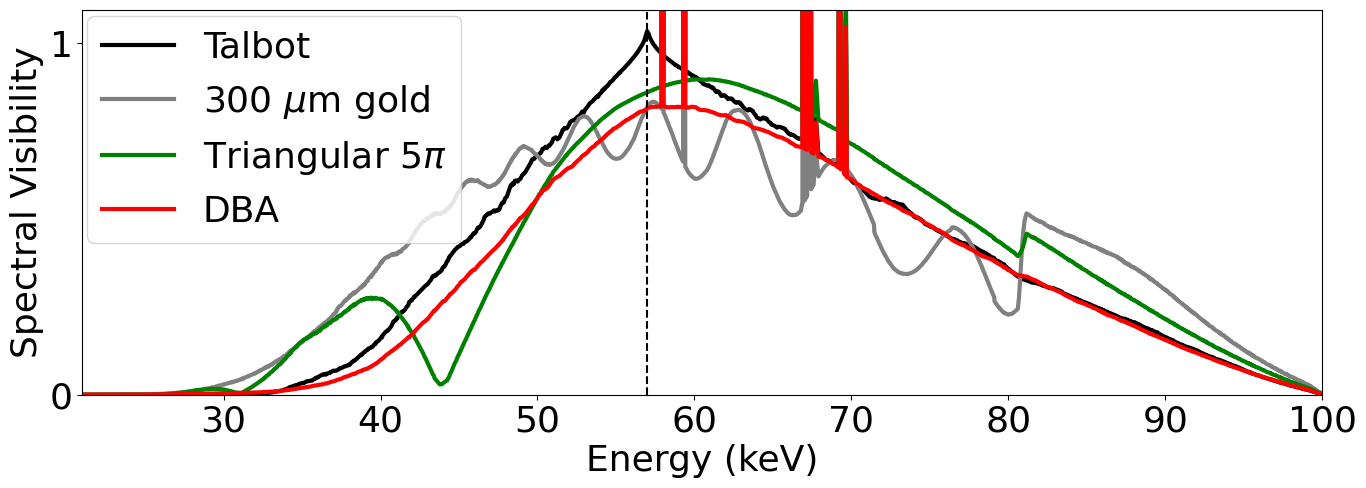

In [60]:
font_size=26
fig_, axs = plt.subplots(nrows = 1, ncols=1, figsize=(16,5))
design_energy=57000
kilo = 1000
plt.plot(eng_tli[sorting]/kilo, vis_an_tli[sorting,0]*eng_spectral[sorting], color="black", label="Talbot", linewidth=3)
plt.plot(eng_tli[sorting]/kilo, vis_an_abs[sorting,0]*eng_spectral[sorting], color="grey", label="300 $\mu$m gold", linewidth=3)
plt.plot(eng_tli[sorting]/kilo, vis_an_tri[sorting,0]*eng_spectral[sorting], color="green", label=f"Triangular 5$\pi$", linewidth=3)
plt.plot(eng_tli[sorting]/kilo, vis_an_dba_inv[sorting,0]*eng_spectral[sorting], color="red", label="DBA", linewidth=3)
plt.axvline(design_energy/kilo, color="black", linestyle="--")
plt.xlabel("Energy (keV)", fontsize=font_size)
plt.ylabel(r"Spectral Visibility", fontsize=font_size)
plt.xlim(21000/kilo, 100000/kilo)
plt.ylim(0,0.001)

axs.xaxis.label.set_size(font_size)
axs.set_yticklabels([])
axs.yaxis.label.set_size(font_size)
axs.xaxis.set_tick_params(labelsize=font_size)
axs.yaxis.set_tick_params(labelsize=font_size)

x_ticks = np.array([0,(vis_an_tli[sorting,0]*eng_spectral[sorting])[1001].max()])
my_xticks = ["0", "1"]
axs.set_yticks(x_ticks, my_xticks)


axs.legend(loc="upper right", bbox_to_anchor=(0.32, 1.03), fontsize=font_size)